In [1]:
!pip install -q scikit-learn pandas numpy matplotlib joblib nltk

In [2]:
from pathlib import Path
import re, string, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
import joblib

# Optional lemmatization (off by default; turn on later to compare)
USE_LEMMATIZATION = False
try:
    import nltk
    from nltk.stem import WordNetLemmatizer
    _HAS_NLTK = True
    lemmatizer = WordNetLemmatizer()
except Exception:
    _HAS_NLTK = False
    lemmatizer = None

RANDOM_STATE = 42
TEST_SIZE = 0.2
N_SPLITS = 5

# Point to your dataset (must have columns: text,label)
DATA_CSV = Path(r"C:\Users\Admin\IMDBDataset.csv")
OUT_DIR = Path("outputs"); OUT_DIR.mkdir(exist_ok=True)
MODEL_DIR = Path("models"); MODEL_DIR.mkdir(exist_ok=True)

In [3]:
if USE_LEMMATIZATION and _HAS_NLTK:
    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        nltk.download('wordnet', quiet=True)
    try:
        nltk.data.find('corpora/omw-1.4')
    except LookupError:
        nltk.download('omw-1.4', quiet=True)

In [4]:
_PUNCT_TABLE = str.maketrans("", "", string.punctuation)

def simple_clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text.lower()
    t = t.translate(_PUNCT_TABLE)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def lemmatize_text(text: str) -> str:
    if not USE_LEMMATIZATION or not _HAS_NLTK or lemmatizer is None:
        return text
    tokens = text.split()
    lemmas = [lemmatizer.lemmatize(tok) for tok in tokens]
    return " ".join(lemmas)

def preprocess_series(s: pd.Series) -> pd.Series:
    s = s.fillna("").astype(str).map(simple_clean)
    if USE_LEMMATIZATION and _HAS_NLTK:
        s = s.map(lemmatize_text)
    return s

In [5]:
if not DATA_CSV.exists():
    # Quick fallback: create a tiny sample to verify everything works
    sample = pd.DataFrame({
        "text": [
            "I absolutely loved this movie!", "Terrible product, very disappointed.",
            "Great value for money.", "Worst service ever.", "Amazing quality and fast delivery!"
        ],
        "label": ["positive","negative","positive","negative","positive"]
    })
    DATA_CSV.parent.mkdir(parents=True, exist_ok=True)
    sample.to_csv(DATA_CSV, index=False)
    print(f"Created sample dataset at {DATA_CSV.resolve()}")

df_raw = pd.read_csv(DATA_CSV)

# find columns
text_col = next((c for c in df_raw.columns if c.lower() in {"text","review","content","sentence","comment"}), None)
label_col = next((c for c in df_raw.columns if c.lower() in {"label","sentiment","target","polarity"}), None)
if text_col is None or label_col is None:
    raise ValueError("CSV must have columns like text/review/content and label/sentiment/target.")

df = df_raw[[text_col, label_col]].rename(columns={text_col:"text", label_col:"label"})
df.head()

,text,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
X = preprocess_series(df["text"])
y = df["label"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    ngram_range=(1,2),
    sublinear_tf=True,
    strip_accents='unicode',
)

models = {
    "NaiveBayes": MultinomialNB(),
    "LinearSVM": LinearSVC(),
    "KNN": KNeighborsClassifier(),
}

param_grids = {
    "NaiveBayes": {"clf__alpha": [0.5, 1.0]},
    "LinearSVM": {"clf__C": [0.5, 1.0, 2.0]},
    "KNN": {"clf__n_neighbors": [5, 11], "clf__weights": ["uniform","distance"]},
}


[Training] NaiveBayes
              precision    recall  f1-score   support

    negative     0.8882    0.9054    0.8967      5000
    positive     0.9035    0.8860    0.8947      5000

    accuracy                         0.8957     10000
   macro avg     0.8958    0.8957    0.8957     10000
weighted avg     0.8958    0.8957    0.8957     10000



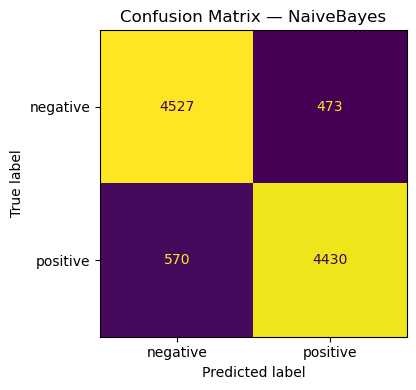


[Training] LinearSVM
              precision    recall  f1-score   support

    negative     0.9281    0.9162    0.9221      5000
    positive     0.9173    0.9290    0.9231      5000

    accuracy                         0.9226     10000
   macro avg     0.9227    0.9226    0.9226     10000
weighted avg     0.9227    0.9226    0.9226     10000



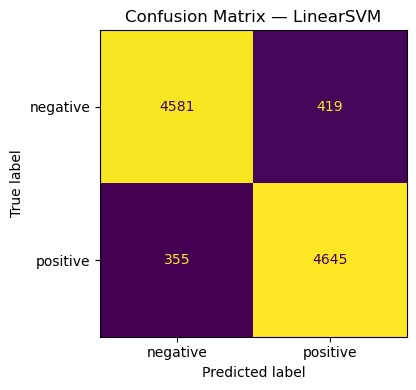


[Training] KNN


D:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.84213644]
  warnings.warn(


              precision    recall  f1-score   support

    negative     0.8797    0.8102    0.8435      5000
    positive     0.8241    0.8892    0.8554      5000

    accuracy                         0.8497     10000
   macro avg     0.8519    0.8497    0.8495     10000
weighted avg     0.8519    0.8497    0.8495     10000



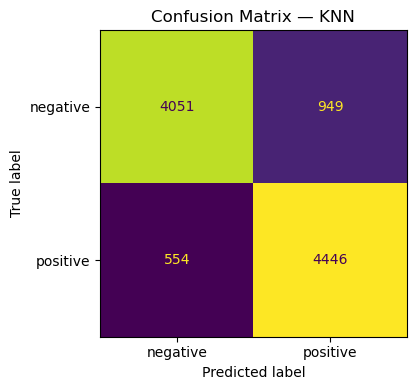


Best model: LinearSVM F1-macro: 92.26 %


In [8]:
results = []
best_f1 = -1.0
best_name = None
best_estimator = None

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
labels_sorted = sorted(y.unique())

for name, model in models.items():
    print(f"\n[Training] {name}")
    pipe = Pipeline([("tfidf", vectorizer), ("clf", model)])
    grid = GridSearchCV(
        pipe, param_grids.get(name, {}), scoring="f1_macro", cv=cv, n_jobs=-1, refit=True
    )
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")
    prec= precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)

    print(classification_report(y_test, y_pred, digits=4))

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)
    fig, ax = plt.subplots(figsize=(5,4))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted).plot(ax=ax, colorbar=False)
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()

    results.append({
        "model": name,
        "best_params": grid.best_params_,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    })

    if f1 > best_f1:
        best_f1 = f1
        best_name = name
        best_estimator = grid.best_estimator_

print("\nBest model:", best_name, "F1-macro:", round(best_f1*100,2), "%")

In [9]:
metrics_df = pd.DataFrame([
    {"Model": r["model"],
     "Accuracy (%)": round(r["accuracy"]*100, 2),
     "Precision (%)": round(r["precision"]*100, 2),
     "Recall (%)": round(r["recall"]*100,  2),
     "F1-Score (%)": round(r["f1"]*100,    2)}
    for r in results
])
display(metrics_df)

metrics_path = OUT_DIR / "metrics_summary.csv"
metrics_df.to_csv(metrics_path, index=False)
print("Saved:", metrics_path.resolve())

,Model,Accuracy (%),Precision (%),Recall (%),F1-Score (%)
0,NaiveBayes,89.57,89.58,89.57,89.57
1,LinearSVM,92.26,92.27,92.26,92.26
2,KNN,84.97,85.19,84.97,84.95


Saved: C:\Users\Admin\outputs\metrics_summary.csv


In [10]:
assert best_estimator is not None, "No model trained."
model_path = MODEL_DIR / f"best_model_{best_name}.joblib"
joblib.dump(best_estimator, model_path)
summary = {"best_model": best_name, "best_f1_macro(%)": round(best_f1*100,2), "model_path": str(model_path)}
with open(OUT_DIR / "summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
summary

{'best_model': 'LinearSVM',
 'best_f1_macro(%)': 92.26,
 'model_path': 'models\\best_model_LinearSVM.joblib'}

In [12]:
def predict_text(model, text: str):
    t = text.lower()
    t = t.translate(str.maketrans("", "", string.punctuation))
    t = re.sub(r"\s+"," ", t).strip()
    series = pd.Series([t])
    pred = model.predict(series)[0]
    conf = None
    if hasattr(model.named_steps["clf"], "decision_function"):
        dfun = model.named_steps["clf"].decision_function(series)
        # map to [0,1] approx via sigmoid of max margin
        conf = float(1/(1+np.exp(-np.max(dfun)))) if np.ndim(dfun) else float(1/(1+np.exp(-dfun)))
    return {"text": text, "prediction": str(pred), "confidence": conf}

loaded = joblib.load(model_path)
predict_text(loaded, "I love this so much, highly recommended!")

ValueError: could not convert string to float: 'i love this so much highly recommended'